In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

Two versions of **GaussianCopulaImp** are available: one as a Python package available from PyPI, and the other as a R package (soon available from CRAN). Both versions use the same algorithms and have the same functionality. Here we use the Python version to demonstrate how to use **GaussianCopulaImp** correctly and properly.

## Quick start

As a quick start illustration, we first use nine demographic variables from the 2014 General Social Survey data: age (`AGE`), highest degree (`DEGREE`), income (`RINCOME`), subjective class identification (`CLASS`), satisfication with the work (`SATJOB`), weeks worked last year (`WEEKSWRK`), general happiness (`HAPPY`) and condition of health (`HEALTH`). All variables are ordinal variables encoded as integers, although with varying number of ordinal categories. The ordinal categories could be exact numbers such as $0, 1, \cdots, 52$ for `WEEKSWRK`. It could also be ordered categories, for example 1, 2, 3 for the question "how would you say things are these days" (`HAPPY`) correspond to "Very happy", "Pretty happy", "Not too happy".  This dataset comes with many missing values due to anwsers like "Don't know", "No answer", "Not applicable", etc.

GSS dataset size (2538, 8)


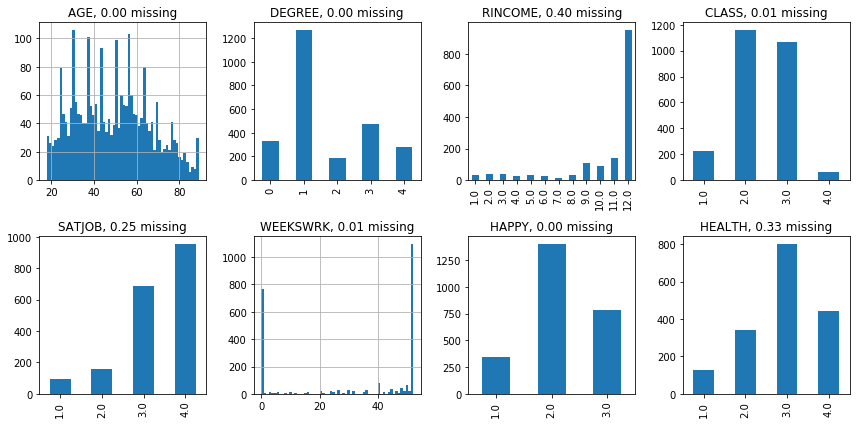

In [3]:
from GaussianCopulaImp.helper_data import load_GSS
data_gss = load_GSS()
print(f'GSS dataset size {data_gss.shape}')
fig, axes = plt.subplots(2, 4, figsize=(12,6))
for i,col in enumerate(data_gss):
    if col in ['AGE', 'WEEKSWRK']:
        data_gss[col].dropna().hist(ax=axes[i//4, i%4], bins=60)
    else:
        to_plot=data_gss[col].dropna().value_counts().sort_index()
        to_plot.plot(kind='bar', ax=axes[i//4, i%4])
    _title = f'{col}, {data_gss[col].isna().mean():.2f} missing'
    axes[i//4, i%4].set_title(_title)
plt.tight_layout()
fig.savefig('GSS_histogram.pdf', bbox_inches='tight')

In [3]:
#fig.savefig('GSS_histogram.pdf', bbox_inches='tight')

We further create $10\%$ missing entries for methods evaluation by randomly sampling the observed entries without replacement. 

In [4]:
from GaussianCopulaImp.helper_mask import mask_MCAR
gss_masked = mask_MCAR(X=data_gss, mask_fraction=.1, seed=101)

The Python package has an API consistent with the `sklearn.impute` module. To impute the missing entries in an incomplete dataset, we simply create a model instance and call `fit_transform(X)` with the default setting. The default choice uses `training_mode='standard'`, which corresponds to the standard EM algorithm in [Our KDD]. 

In [5]:
from GaussianCopulaImp.gaussian_copula import GaussianCopula
model = GaussianCopula()
Ximp = model.fit_transform(X=gss_masked)

Note variables in GSS dataset have different scales. If we do not want the imputation evaluation to be dominated by a single variable with large scale, we can use the scaled mean abosulte error (SMAE), the imputation MAE of a method scaled by the imputation MAE of the median imputation, for each variable and then use its average as the overall evaluation error. As shown below, the Gaussian copula imputation improves over median imputaiton by $13\%$.

In [6]:
from GaussianCopulaImp.helper_evaluation import get_smae
smae = get_smae(x_imp=Ximp, x_true=data_gss, x_obs=gss_masked)
print(f'SMAE average over all variables: {smae.mean():.3f}')

SMAE average over all variables: 0.891


We can also extract the copula correlation estimate to see which variables are correlated. Those estimated correlation may be seen as the a rank-based correlation like kendall's tau correlation.

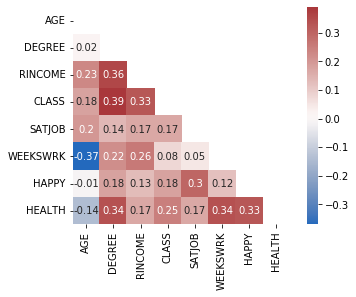

In [8]:
import seaborn as sns
copula_corr_est = model.get_params()['copula_corr']
mask = np.zeros_like(copula_corr_est)
mask[np.triu_indices_from(mask)] = True
names = data_gss.columns
fig = sns.heatmap(np.round(copula_corr_est,2), 
                  xticklabels=names, yticklabels=names, 
                  annot=True, mask=mask, square=True, cmap='vlag')

In [51]:
#fig.figure.savefig('GSS_corr.pdf', bbox_inches='tight')

In [10]:
for key,value in model.get_vartypes(feature_names = names).items():
    print(f'{key}: {value}')

continuous: ['AGE']
ordinal: ['DEGREE', 'RINCOME', 'CLASS', 'SATJOB', 'WEEKSWRK', 'HAPPY', 'HEALTH']
lower_truncated: []
upper_truncated: []
twosided_truncated: []


In [9]:
np.fill_diagonal(copula_corr_est, 0)
corr_est = pd.DataFrame(copula_corr_est, columns = names, index=names)

def most_correlated(x):
    index = x.abs().idxmax()
    corr = x[index]
    return index, corr

corr_est.apply(most_correlated)

AGE         (WEEKSWRK, -0.37179270381203516)
DEGREE           (CLASS, 0.3913561044161574)
RINCOME        (DEGREE, 0.35681782608431944)
CLASS           (DEGREE, 0.3913561044161574)
SATJOB           (HAPPY, 0.2982571539879447)
WEEKSWRK         (AGE, -0.37179270381203516)
HAPPY           (HEALTH, 0.3347964974483139)
HEALTH         (DEGREE, 0.34398226652544306)
dtype: object

### Determine the variable types

When fitting the Gaussian copula model in executing `fit_transform()`, the model needs to know which variables are continuous and which are ordinal. We did not specify data types in the previous call because the model can use the default setting to automatically make the decision. We could find out which variables are treated as continuous vairables during fitting, by accessing the attribute `cont_indices`. As shown below, the default setting treats only `AGE` as a continuous variable.

In [16]:
names[model.cont_indices].to_list()

['AGE']

Correctly specifying the variable types is very important because the model can fail to converge if a variable having large multiplicity of some value is set as a continuous variable. That is because the Gaussian copula model assumes that the data has joint normal distribution after some monotonic transformation. However, the transformation does not change the multiplicity. Thus no matter what transformation supplied, the joint normal distribution assumption is seriously violated in the data with large multiplicity. Such problem has also been observed in [Cite Peter Hoff]. If we have domain knowledge on the variable types, we can directly tell the model the continuous varibles' location by `model.fit_transform(cont_indices = cont_indices)` with an array-like variable `cont_indices` containing all continuous variables indices. 

If we do not have such prior knowledge, the default setting is a good approach to go with. It tries to guess the variable type based on the mode occurrence ratio: a variable is categorized as ordinal if and only if its mode occurrence ratio is above the minimal allowed value `min_ord_ratio=10%`. This criterion is created to prevent a variable with high multiplicity from being treated as continuous. For example, all variables with no more than 10 ordinal levels will be treated as ordinal. For those variables with more than 10 ordinal levels, the model only treats them as ordinal if the distribution is significantly spiked at some level. We can also change the threshold when creating a model `GaussianCopula(min_ord_ratio=0.1)`, if needed. More concretely, let us look into the mode occurence ratio across variables.

In [11]:
from tabulate import tabulate
def key_freq(col):
    freq = col.value_counts(normalize=True)
    key_freq = {'mode':freq.max()}
    _min, _max = col.min(), col.max()
    key_freq['min'] = freq[_min]
    key_freq['max'] = freq[_max]
    freq_middle = freq.drop(index = [_min, _max])
    key_freq['mode_nominmax'] = freq_middle.max()/freq_middle.sum()
    return pd.Series(key_freq).round(2)
table = data_gss.apply(lambda x: key_freq(x.dropna())).T
print(tabulate(table, headers='keys', tablefmt='psql'))

+----------+--------+-------+-------+-----------------+
|          |   mode |   min |   max |   mode_nominmax |
|----------+--------+-------+-------+-----------------|
| AGE      |   0.02 |  0    |  0.01 |            0.02 |
| DEGREE   |   0.5  |  0.13 |  0.11 |            0.66 |
| RINCOME  |   0.62 |  0.02 |  0.62 |            0.26 |
| CLASS    |   0.46 |  0.09 |  0.03 |            0.52 |
| SATJOB   |   0.5  |  0.05 |  0.5  |            0.81 |
| WEEKSWRK |   0.44 |  0.31 |  0.44 |            0.13 |
| HAPPY    |   0.55 |  0.13 |  0.31 |            1    |
| HEALTH   |   0.47 |  0.07 |  0.26 |            0.7  |
+----------+--------+-------+-------+-----------------+


Now it is clear why only `AGE` is treated as continuous. While `WEEKSWRK` has many ordinal categories, it is mostly appearing in two cateories: 0 and 52, and thus has large mode occurence frequency $0.44$. In contrast, the probability mass of `AGE` is more spreaded out and thus it has a much smaller mode occurence frequency $0.02$. But what happens if we insist on setting `WEEKWRK` as an continuous variable? We will see that would cause the algorithm to diverge, after introducing how to diagnose the model convergence in next section.

### Stopping criterion

The package tracks the model parameters change as the stopping criterion. Specifically, the algorithm stops when $\frac{||\Sigma_{t+1}-\Sigma_{t}||_F}{||\Sigma_{t}||_F}$ is below the specified `tol`, where $\Sigma_t$ is the model parameter estiamte at the $t$-th iteration. The default value  $0.001$ works well in most cases. The default maximal iterations, `max_iter`, is set as $50$. In practice, the algorithm converges in less than 30 iteraitons for most cases.

Recall the actual objective value is the marginal likelihood at the observed locations, averaged over all instances. When all variables are continuous, the marginal distribution is actually multivariate Gaussian and thus easy to compute. The actual objective value can then be tracked to better monitor the algorithm's performance. However, when there exists ordinal variables, the mariginal distribution is very hard to compute. Still, the package provides an approximated likelihood value by treating the ordinal variables as continuous. Note the special treatment is not applied to and thus will not hurt the actual algorithm fitting. In most cases and even those where all variables are ordinal, the computed likelihood values are found to be good approximation: it monotonically incraeses during the fitting process and finally converges. The computed likelihood also provides an early stopping criterion: the algorithm will stop if the likelihood values fail to increase by a certain amount (default is $1\%$). Such early stopping criterion is found to be effective against overfitting sometimes. Now let us see its effect on the GSS dataset. To cancel the early stopping criterion, we can simply set the minimal required likelihood increase ratio, `likelihood_min_increase`, to zero. We can also monitor the parameter update ratio and the likelihood value during fitting, by setting `verbose=1` when creating the model.

In [12]:
model_longer = GaussianCopula(verbose=1)
Ximp_longer = model_longer.fit_transform(X=gss_masked)

Iteration 1: copula parameter change 0.1168, likelihood -9.6913
Iteration 2: copula parameter change 0.0644, likelihood -9.5869
Iteration 3: copula parameter change 0.0366, likelihood -9.5278
Iteration 4: copula parameter change 0.0220, likelihood -9.4942
Iteration 5: copula parameter change 0.0140, likelihood -9.4744
Iteration 6: copula parameter change 0.0093, likelihood -9.4623
Convergence achieved at iteration 6


In [13]:
m = GaussianCopula(verbose=1)
get_err = lambda x: get_smae(x, x_true=data_gss, x_obs=gss_masked).mean()
r = m.fit_transform_evaluate(X=gss_masked, eval_func=get_err, num_iter=15)

Iteration 1: copula parameter change 0.1168, likelihood -9.6913
Iteration 2: copula parameter change 0.0644, likelihood -9.5869
Iteration 3: copula parameter change 0.0366, likelihood -9.5278
Iteration 4: copula parameter change 0.0220, likelihood -9.4942
Iteration 5: copula parameter change 0.0140, likelihood -9.4744
Iteration 6: copula parameter change 0.0093, likelihood -9.4623
Iteration 7: copula parameter change 0.0063, likelihood -9.4545
Iteration 8: copula parameter change 0.0044, likelihood -9.4494
Iteration 9: copula parameter change 0.0032, likelihood -9.4460
Iteration 10: copula parameter change 0.0023, likelihood -9.4437
Iteration 11: copula parameter change 0.0017, likelihood -9.4421
Iteration 12: copula parameter change 0.0012, likelihood -9.4409
Iteration 13: copula parameter change 0.0009, likelihood -9.4401
Iteration 14: copula parameter change 0.0007, likelihood -9.4396
Iteration 15: copula parameter change 0.0005, likelihood -9.4392


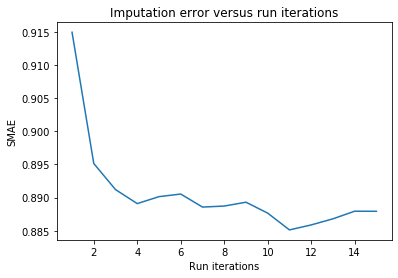

In [18]:
plt.plot(list(range(1, 16, 1)), r['evaluation'])
plt.title('Imputation error versus run iterations')
plt.xlabel("Run iterations")
plt.ylabel("SMAE")
plt.savefig('GSS_imp_error.pdf', bbox_inches='tight')

We can access the number of iteratios of the previous model run by accessing attribute `n_iter_`. As shown beloe, the algorithm takes 8 more iterations to achieve convergence, after canceling the early stopping criterion. 

In [15]:
print(f'Converged in {model.n_iter_} with early stopping, but {model_longer.n_iter_} without early stopping')

Converged in 5 with early stopping, but 15 without early stopping


The likelihood values keep climbing at a slow rate (below $1\%$), as shown below.

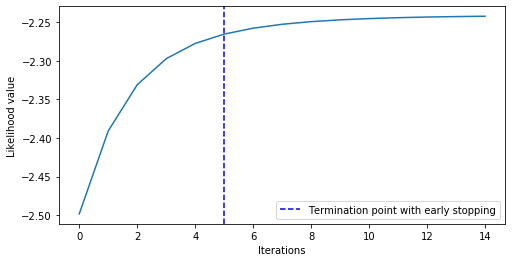

In [16]:
fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(model_longer.likelihood)
ax.set_ylabel('Likelihood value')
ax.set_xlabel('Iterations')
ax.axvline(x=model.n_iter_, label='Termination point with early stopping', color='b', linestyle='--')
_ = ax.legend()

Now we compute the imputation error of the model trained without early stopping. As shown below, its imputation error improves over the model trained with early stopping by small amount, at the cost of triple computation time.

In [17]:
smae_longer = get_smae(x_imp=Ximp_longer, x_true=np.array(data_gss), x_obs=data_gss_masked)
smae_longer.mean()

0.8622322496621087

It is observed that canceling the early stop criterion mostly achieve slight improvement, but often at the price of much longer time to converge due to slow convergence in the late stage. Whether to use the early stopping criterion should depend on the task. If we just want a pretty good estimator in short time, the default choice `tol=0.001, likelihood_min_increase=0.01` is good to go. If we want to have an estimator that fits the data as well as possible, we could decrease either `tol` (smaller positive) or `likelihood_min_increase` (as low as 0). The particular choice can be tuned using a validation set, but in general the results from the default setting will be close to that from a carefully tuned setting. 

### Model divergence diagnosis: an example of improper data types specification

Recall previously we found the variable `WEEKSWRK` has large mode occurence ratio and thus is treated as an ordinal variable. desptie it has many ordinal levels. Now let us see what happens if we change its data type to continuous. Wo do so by manually provide `cont_indices` when calling `fit_transform`.

In [18]:
m_gss_v2 = GaussianCopula(verbose=1, max_iter=10)
Ximp_gss_v2 = m_gss_v2.fit_transform(data_gss_masked, cont_indices = [0, 5])
print(f'Continuous variables: {names[m_gss_v2.cont_indices].to_list()}')

Iteration 1: copula correlation update ratio 0.1206, likelihood -4.4086
Iteration 2: copula correlation update ratio 0.0739, likelihood -4.4205
Iteration 3: copula correlation update ratio 0.0499, likelihood -4.4652
Iteration 4: copula correlation update ratio 0.0369, likelihood -4.5352
Iteration 5: copula correlation update ratio 0.0293, likelihood -4.6210
Iteration 6: copula correlation update ratio 0.0258, likelihood -4.7108
Iteration 7: copula correlation update ratio 0.0265, likelihood -4.7961
Iteration 8: copula correlation update ratio 0.0308, likelihood -4.8752
Iteration 9: copula correlation update ratio 0.0366, likelihood -4.9526
Iteration 10: copula correlation update ratio 0.0411, likelihood -5.0376
Convergence not achieved at maximum iterations
Continuous variables: ['AGE', 'WEEKSWRK']


In [19]:
smae_v2 = get_smae(x_imp=Ximp_gss_v2, x_true=data_gss.to_numpy(), x_obs=data_gss_masked)
smae_v2.mean()

0.9417905251219901

We stopped the algorithm after 10 iterations since it already started to diverge. The result is quite surprising that changing a single variable's type can make the whole algorithm diverge. The resulting imputation error also largely increases. It is a strong notice that we need to specify data types properly. Luckily, the default setting works well in most cases experimented. 

## Acceleration through parallelism, minibatch training, and low rank structure

Running `GaussianCopula()` with the default setting (`training_mode='standard'`) has computational complexity $O(np^3)$ for each EM iteration. However, we can achieve great amount of acceleration if using it cleverly. 
To speed up the model's execution, three tools are provided: parallelism, minibatch training and low rank structure.

Parallelism is the most straightforward and the easiest acceleration tool to use. By calling `GaussianCopula(n_jobs=m)`, we can distribute the computation across $n$ rows using $m$ cores. It is best suited for datasets with large $n$ and small $p$. 

Minibatch training, invoking by calling `GaussianCopula(training_mode='minibatch-offline')`, also aims to accelerate the model's exceution for large $n$ and small $p$ problem. It randomly shuffles the data and divide them into minibatches, and then perform model updates at each minibatch. The algorithm converges much faster as the model is updated more frequently. It can also be used together with parallelism to distribute the computation across rows inside a minibatch, by calling `GaussianCopula(training_mode='minibatch-offline', n_jobs=m)`. Although it requires additional work to choose the learning rates, batch size and a different stopping criterion, we will see the selection is quite simple shortly.

Low rank structure is developed for large $p$ problem ($p\geq 1000$) where the $O(np^3)$ computation is unaffordable. The model created by calling `LowRankGaussianCopula(rank=k)` has $O(npk^2)$ complexity per iteration, making it efficient to run even $p$ is at the scale of thousands. It also supports parallelism by specifying `n_jobs`, and the computation is distributed over all rows and all columns. Unfortunately, the minibatch training for `LowRankGaussianCopula()` is nontrivial and has not yet been developed. Still, if working with large $n$ and large $p$ dataset, using `LowRankGaussianCopula(rank=k, n_jobs=m)` with parallelism should be satisfying.

For the following, we will see guidelines and examples on how to use minibatch training and low rank Gaussian copula properly.

### Acceleration for large $n$ problem: minibatch training

Recall at each EM iteration for minibatch training, the update rule is $\Sigma_{t+1}=(1-\eta_{t+1})\Sigma_t+\eta_{t+1}\hat\Sigma$, where $\Sigma_t$ is the model estiamte at iteration $t$, $\hat \Sigma$ is the new estiamte on the used minibatch and $\eta_t$ is the step size. Thus to use minibatch training, we need to specify the decaying step size $\{\eta_t\}$. Also, we need to determine on the minibatch size $s$ and the number of iterations $k$ to run. 

According to [online EM and our online], the decayling step size should satisfy $\sum_{t=1}^\infty \eta_t=\infty$ and $\sum_{t=1}^\infty \eta_t^2<\infty$. To conveniently ensure $\eta_t \in (0, 1)$ for all $t$, it is recommended to use $\eta_t = c/(c+t)$ with $c>0$. Roughly speaking, the model receives $50\%$ udpate at $c$-th iteration and $5\%$ update at $19c$-th iteration, when $c$ is an integer. It is often sufficient to tune $c$ in the range $(0, 10)$, and $c=5$ works well in many settings experimented. 

On the selection of batch size $s$, the update rule [quote equation] requires $s\geq p$ to avoid singular matrix operation [our online]. Still, it is observed that even if this requirement is slightly violated (not too small $s$), the algorithm continues to run smoothly. For the purpose to accelerate the algorithm, it should be easy to satisfy $s\geq p$, since if $p$ is too large, we should use `LowRankGaussianCopula()` instead. 

The selection of maximum number of iterations matters more now, because the stochastic fluctuation over minibatches makes it hard to decide convergence based on the parameter update ratio or the likelihood increase. Thus this package disables the early stopping criterion based on the likelihodd increase for minibatch traing. While the algorithm still converges when the parameter update ratio goes below `tol`, that mostly happens when $\eta_t$ gets close to $0$ when $t$ is large enough. Instead of specifying an exact maxmium number of iterations, it may be more convenienet to select it based on the number of passes desired, i.e. $n_{\textit{iter}}=\left \lceil{\frac{n}{s}}\right \rceil  \times n_{\textit{pass}}$, where $s$ is the selected minibatch size. Often using $n_{\textit{pass}}=2$ (the default setting) or $3$ gives good enough results.

To use the default setting of step size $\eta_t=\frac{5}{t+5}$, minibatch size $s=100$ and the maximum number of iterations $n_{\textit{iter}}=\left \lceil{\frac{n}{s}}\right \rceil  \times 2$, simple run the following:

In [19]:
t1=time.time()
model_minibatch = GaussianCopula(training_mode='minibatch-offline')
Ximp_batch = model_minibatch.fit_transform(X=gss_masked)
t2=time.time()
print(f'Runtime: {t2-t1:.2f} seconds')
smae_batch = get_smae(x_imp=Ximp_batch, x_true=data_gss, x_obs=gss_masked)
print(f'Imputation error: {smae_batch.mean():.3f}')

Runtime: 17.58 seconds
Imputation error: 0.8861


In [20]:
t1=time.time()
GaussianCopula().fit_transform(X=gss_masked)
t2=time.time()
print(f'Runtime: {t2-t1:.2f} seconds')

Runtime: 50.07 seconds


Interestingly, the imputation from minibatch training not only reduces the runtime from $50$s to $19$s but also reduces the imputation error from $0.8660$ to $0.8497$! Here we used a relative small dataset for illustration purpose. The acceleration will be more significant (as large as $85\%$ time reduction) on larger datasets [cite our online].

We could also supply their own choice of step size, minibatch size and the maximum number of iterations by changing either `num_pass` or `max_iter`.  When `num_pass` is set as an integer, the parameter `max_iter` will not be used. To directly specify `max_iter`, set `num_pass` as `None`. For example, the following created `model_minibatch_v2` will perform exaclty the same as the previously created `model_minibatch`.

In [22]:
max_iter=np.ceil(data_gss_masked.shape[0]/100*2).astype(np.int32)
model_minibatch_v2 = GaussianCopula(training_mode='minibatch-offline', 
                                    stepsize_func = lambda t, c=5:c/(c+t),
                                    batch_size = 100,
                                    num_pass = None, 
                                    max_iter = max_iter
                                   )

### Acceleration for large $p$ problem: low rank structure

Recall the low rank structure refers to that the actual observed $p$-dimensional data is generated by transforming and corrupting a latent $k$-dimensional variable, and the copula correlation matrix has the decomposition $\Sigma = WW^\top +\sigma^2 \mathrm{I}_p$ with $W\in \mathbb{R}^{p\times k}$ and $\sigma^2\in (0,1)$. We need to tune the rank $k$ to have the best possible result using the low rank Gaussian copula model. In practice, it is found the optimal rank is often below $20$, even when there are around $2500$ variabels [cite LRGC paper]. Besides of the imputed dataset, the fitted model also return estimates of $W$ and $\sigma^2$. The estimated $\sigma^2$ tells us how much the model explains the data. It stands for the variance proportion of the noise: $0$ means no noise and thus the model perfectly explains the data, while $1$ means completely noise and the model cannot explain the data at all.

To show the speedup of the low rank Gaussian copula model, we use a subset of the MovieLens1M dataset. More specificly, we select $150$ movies with most ratings and users who rates at least $50$ movies among them. That yields a dataset of size $1858\times 150$ with observation ratio $46.2\%$. The dataset is selected to have a moderate large $p$, so that it does not take too long to run `GaussianCopula()` for runtime comparison. We further mask $10\%$ entries for evaluation. 

In [33]:
from GaussianCopulaImp.helper_data import load_movielens1m
data_movie = load_movielens1m(num = 150, min_obs = 20, verbose = True)

The loaded dataset consists of 4045 users and 150 movies with 36.4% ratings observed


In [19]:
data_movie_masked = mask_MCAR(X=data_movie, mask_fraction=0.1, seed=101)

Now we run `GaussianCopula()` as well as `LowRankGaussianCopula()` with rank $10$. Here our goal is not to choose the optimal rank, but rather show the runtime comparison between two models. We also enable parallelism for both methods, using $4$ cores (mostly available on a laptop), for faster execution.

In [20]:
model_movie = GaussianCopula(verbose=1)
a = time.time()
Ximp_movie = model_movie.fit_transform(X=data_movie_masked)
b = time.time()
n_iter = model_movie.n_iter_
obj = model_movie.likelihood[-1]
print(f'Achieved likelihood {obj:.3f} using {(b-a)/60:.2f} mins in {n_iter} iterations')

Iteration 1: copula parameter change 0.2727, likelihood -101.6251
Iteration 2: copula parameter change 0.2000, likelihood -101.0538
Iteration 3: copula parameter change 0.1231, likelihood -100.5606
Iteration 4: copula parameter change 0.0722, likelihood -100.1772
Iteration 5: copula parameter change 0.0440, likelihood -99.8914
Iteration 6: copula parameter change 0.0292, likelihood -99.6768
Iteration 7: copula parameter change 0.0210, likelihood -99.5111
Iteration 8: copula parameter change 0.0160, likelihood -99.3795
Iteration 9: copula parameter change 0.0127, likelihood -99.2722
Iteration 10: copula parameter change 0.0104, likelihood -99.1830
Iteration 11: copula parameter change 0.0086, likelihood -99.1077
Convergence achieved at iteration 11
Achieved likelihood -99.108 using 15.75 mins in 11 iterations


In [21]:
from GaussianCopulaImp.low_rank_gaussian_copula import LowRankGaussianCopula
model_movie_lrgc = LowRankGaussianCopula(rank=8, verbose=1)
a = time.time()
Ximp_movie_lrgc = model_movie_lrgc.fit_transform(X=data_movie_masked)
b = time.time()
n_iter = model_movie_lrgc.n_iter_
obj = model_movie_lrgc.likelihood[-1]
print(f'Achieved likelihood {obj:.3f} using {(b-a)/60:.2f} mins in {n_iter} iterations')
noise_ratio = model_movie_lrgc.get_params()['copula_noise_ratio']
print(f'Estimated noise variance ratio: {noise_ratio:.2f}')

Interation 1: noise ratio 0.6922, copula parameter change 0.0757, likelihood -100.3473
Interation 2: noise ratio 0.6823, copula parameter change 0.0490, likelihood -100.3593
Interation 3: noise ratio 0.6732, copula parameter change 0.0353, likelihood -100.2857
Interation 4: noise ratio 0.6655, copula parameter change 0.0272, likelihood -100.1981
Interation 5: noise ratio 0.6591, copula parameter change 0.0219, likelihood -100.1189
Interation 6: noise ratio 0.6538, copula parameter change 0.0183, likelihood -100.0522
Interation 7: noise ratio 0.6495, copula parameter change 0.0157, likelihood -99.9974
Interation 8: noise ratio 0.6460, copula parameter change 0.0137, likelihood -99.9527
Interation 9: noise ratio 0.6432, copula parameter change 0.0122, likelihood -99.9164
Interation 10: noise ratio 0.6408, copula parameter change 0.0111, likelihood -99.8869
Interation 11: noise ratio 0.6389, copula parameter change 0.0102, likelihood -99.8629
Interation 12: noise ratio 0.6374, copula para

Here are a few interesting facts. First, the per itertion time complexity of `GaussianCopula()` is actually very close to that of `LowRankGaussianCopula()`, that is because the per iteration speedup of `LowRankGaussianCopula()` only exists when $p$ is large enough. Second, `GaussianCopula()` takes 8 more iterations to converge. That is because `LowRankGaussianCopula()` has fewer parameters, i.e. stronger structure regularization. Thus even $p$ is not large enough to let `LowRankGaussianCopula()`  have per significant iteration speedup over `GaussianCopula()`, the low rank Gaussian copula model is still prefered for fast convergence. Third, since low rank Gaussian copula imposes additional strcture constraint and thus search parameters in a smaller space, its maximal likelihood should be smaller than that from the full rank Gaussian copula. That is verified here on the movielens1m dataset. At last, the estiamted noise ratio from `LowRankGaussianCopula()` is $0.59$, indicating small signal-to-noise ratio in the data. On such noisy data, a model with more regularization often performs better. Now let us see the imputation performance between two methods. Since all entries are now in the scale of 1-5, we simply use MAE for evaluation.

In [17]:
from GaussianCopulaImp.helper_evaluation import get_mae
mae_gc=get_mae(x_imp=Ximp_movie, x_true=data_movie, x_obs=data_movie_masked)
mae_lrgc=get_mae(x_imp=Ximp_movie_lrgc, x_true=data_movie, x_obs=data_movie_masked)
print(f'Imputation error: {mae_gc:.3f} for full rank version, {mae_lrgc:.3f} for low rank version')

Imputation error: 0.569 for full rank version, 0.577 for low rank version


In [9]:
from GaussianCopulaImp.helper_evaluation import get_mae
mae_gc=get_mae(x_imp=Ximp_movie, x_true=data_movie, x_obs=data_movie_masked)
mae_gc

0.5640251733881325

In [10]:
# rank 10
from GaussianCopulaImp.helper_evaluation import get_mae
mae_lrgc=get_mae(x_imp=Ximp_movie_lrgc, x_true=data_movie, x_obs=data_movie_masked)
mae_lrgc

0.5725661443616749

The results agree with our intuition: compared to the full rank model, the low rank model has slightly better imputation error. That provides us another guideline on the model selection: `LowRankGaussianCopula()` with small rank should be prefered when there is small signal-to-noise ratio.

## Online missing data imputaiton

To use online training, we need to specify step size $\{\eta_t\}$, batch size $s$ and the size of running windows, which store recent observation for marginal estimation. For step size $\{\eta_t\}$, we could still use decaying step size as in the offline setting. However, the model will gradually stop to learn new data batches. For time series data, it is common for the data distribution to change abruptly at some point or to evolve continuously over time (as shown in the illustration example). Thus for online training, we should prefer a constant step size $\eta\in (0,1)$. The specific value of $\eta$ can be tuned for best performance, but the default value $\eta=0.5$ mostly works well.

The batch size $s$ controls how fast the Gaussian copula model is updated. For offline minibatch training, we see the only requirement is that $s\geq p$. However, for online data, particularly that which is constantly changing, batch size has a much larger impact, because frequent updates can often quickly adapt to a changing distribution. It should now be treated as a hyperparameter to be tuned, with minimal allowed value as $p$.

The window size controls how fast the Gaussian copula model forgets the past observation, which are used for marginal estimation, which should also be treated as a hyperparameter. In general, a longer window works better when the data distributoin is mostly stable but may have a few abrupt changes. On the other hand, if the data distribution changes rapidly, a shorter window is needed. Note the imputation is done by interpolating the observation points in the window, a meaningful window size should be at least $2$. While the default value is set as $200$, we should conduct some preliminary diagnosis on how the data distribution changes to help select a reasonable window size value.

We no longer need to determine on the stopping criterion, since the model keeps updating as new data comes in and will use each data point exactly once for model parameter update. 

For illustration on how to use Gaussian copula model for online data, we now use eight daily recorded economic time series variables from federal reserve bank of St. Louis (FRED), consisting of 2456 days from 2011-11-03 to 2021-10-15. The eight variables are: volatility index `VIX`, corporate bonds index `BAMLH0A0HYM2`, total weighted U.S. dollar index `DTWEXBGS`, U.S. equity market index `SP500`, inflation rate `T10YIE`, interest rate spread `T10Y2Y`, crude oil prices `DCOILWTICO` and China/U.S. foreign exchange rate `DEXCHUS`. We pick three variables (`VIX`, `BAMLH0A0HYM2`, `T10YIE`) to mask $30\%$ entries for online imputaiton task evaluation. 

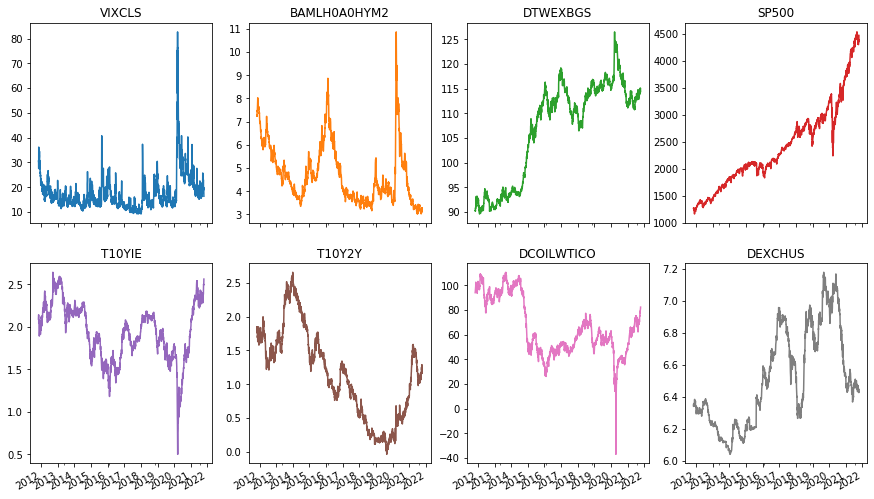

In [149]:
from GaussianCopulaImp.helper_data_generation import load_FRED
data_fred = load_FRED()
names = data_fred.columns.to_list()
_ = data_fred.plot(subplots=True, layout = (2,4), figsize = (15, 9), title=names, legend=False)
col_to_mask = ['VIXCLS', 'BAMLH0A0HYM2', 'T10YIE']
cols_masked = mask_MCAR(X=data_fred[col_to_mask].to_numpy(), mask_fraction=0.3, seed=11, allow_empty_row=True)
fred_masked = np.concatenate((data_fred.drop(columns = col_to_mask).to_numpy(), cols_masked), axis=1)

As shown above, the distribution of all variables evolve over time. Thus we would like to update model as well as forget old observation quickly, as new data comes in. As an exmaple illustration, we use constant step size with its default value $\eta=0.5$, a small batch size $10$ (slightly larger than $p=8$), and a small window size $10$. To enable the online traing, set `training_mode='minibatch-online'`, shown as below:

In [ ]:
model_fred = GaussianCopula(training_mode = 'minibatch-online', 
                            const_stepsize=0.5, 
                            batch_size=10, 
                            window_size=10)

The Gaussian copula model should be fed the entire dataset as input data, in the call `fit_transform()`. Using the batch size provided, the input dataset will be sequentially divided into data batches. For each data batch, the missing entries are firstly imputed using the stored model estimate, and then the observation is used to update the model. For evaluation, we compute the SMAE at each data batch. Since there may be no missing entries to evaluate for data batch of size $10$, we evaluate the online imputation performance using a longer batch of size $40$. 

In [145]:
from GaussianCopulaImp.helper_evaluation import get_smae_batch
X_imp_fred = model_fred.fit_transform(fred_masked)
smae_online = get_smae_batch(X_imp_fred[:,-3:], data_fred[col_to_mask].to_numpy(), cols_masked, batch_size=40)

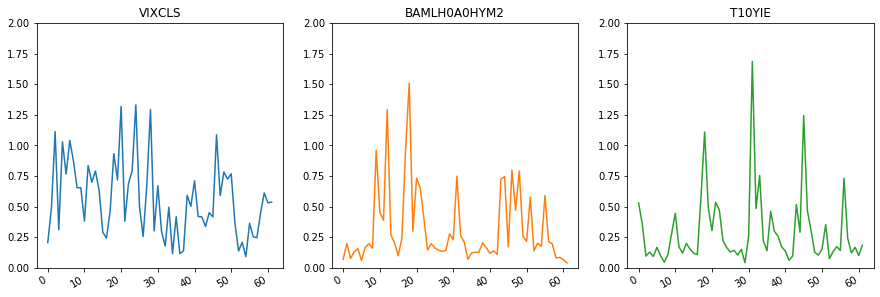

In [154]:
_=pd.DataFrame(smae_online,columns=col_to_mask).plot(figsize = (15, 5), title = col_to_mask, 
                                                     legend=False, subplots=True, layout=(1,3), ylim=(0,2))

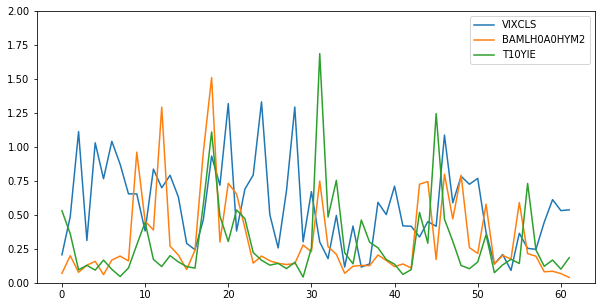

In [155]:
_=pd.DataFrame(smae_online, columns = col_to_mask).plot(figsize = (10, 5), ylim=(0,2))

In [156]:
smae_online.mean(axis=0)

array([0.55958161, 0.32360305, 0.29572361])

Shown above, the overall imputation performance is much better than the median imputation. Although the Gaussian copula imputation may perform worse than the median imputation at some evaluation points, it quickly recovers to outperform at the next evaluation point. That indicates the Gaussian copula model can quickly learn the changing data distribution.

When we use the Gaussian copula to model dataset with all continuous variables, the missing entries have Gaussian distribution with mean and covariance depending on the observed entries, after some monotonic transformation. The Gaussian distribution makes it possible to derive analytic confidence intervals for imputed missing entries, by monotonically transform a Gaussian confidence interval. The monotonic transformation also often makes the built confidence interval asymmetric, which may be desired in many scenarios. 

## Imputation confidence intervals

To illustrate how to derive imputation confidence interval, we use one regression task UCI dataset, the white wine quality dataset. This dataset has 11 continuous features and a rating target from 4898 instances.

In [19]:
from GaussianCopulaImp.helper_data import load_whitewine
data_wine = load_whitewine()
from tabulate import tabulate
print(tabulate(data_wine.head().T,  tablefmt='psql'))

+----------------------+---------+---------+---------+----------+----------+
| fixed acidity        |   7     |   6.3   |  8.1    |   7.2    |   7.2    |
| volatile acidity     |   0.27  |   0.3   |  0.28   |   0.23   |   0.23   |
| citric acid          |   0.36  |   0.34  |  0.4    |   0.32   |   0.32   |
| residual sugar       |  20.7   |   1.6   |  6.9    |   8.5    |   8.5    |
| chlorides            |   0.045 |   0.049 |  0.05   |   0.058  |   0.058  |
| free sulfur dioxide  |  45     |  14     | 30      |  47      |  47      |
| total sulfur dioxide | 170     | 132     | 97      | 186      | 186      |
| density              |   1.001 |   0.994 |  0.9951 |   0.9956 |   0.9956 |
| pH                   |   3     |   3.3   |  3.26   |   3.19   |   3.19   |
| sulphates            |   0.45  |   0.49  |  0.44   |   0.4    |   0.4    |
| alcohol              |   8.8   |   9.5   | 10.1    |   9.9    |   9.9    |
| quality              |   6     |   6     |  6      |   6      |   6      |

We now randomly mask $30\%$ entries as missing among all features and fit a Gaussian copula model to the masked dataset.

In [31]:
X_wine = data_wine.to_numpy()[:,:-1]
X_wine_masked = mask_MCAR(X_wine, mask_fraction=0.3)
model_wine = GaussianCopula()
X_wine_imputed = model_wine.fit_transform(X=X_wine_masked)

Once the Gaussina copula model is fitted, we can extract the imputation confidence intervals by calling function method `get_imputed_confidence_interval()` with incomplete data to be imputed and the desired significance level `alpha`:

In [8]:
ct = model_wine.get_imputed_confidence_interval()
upper, lower = ct['upper'], ct['lower']

You can also call it `model_wine.get_imputed_confidence_interval(X=X_wine_masked)`

The returned confidence intervals only have values at missing entries and `np.nan` is put at all observed entries. Examining the empirical coverage of the returned confidence intervals, we find they are well calibrated.

In [9]:
missing = np.isnan(X_wine_masked)
assert (np.isnan(upper) == (~missing)).all()
cover = (lower[missing] < X_wine[missing]) & (upper[missing] > X_wine[missing])
print(f'Empirical coverage rate: {cover.mean():.3f}')

Empirical coverage rate: 0.943


The confidence intervals are exact if all variables are continuous. In other cases, we find confidence intervals still have good coverage.

## Multiple imputation

Multiple imputation refers to replacing each missing value by multiple different imputed values. The motivation of multiple imputaiton is to reflect the uncertainty in the imputed entries. On main use of multiple imputation is for supervised learning tasks with missing entries among the features. Concretely, we can use draw multiple imputed feature datasets, then train a model for each imputed dataset and at last combine the collection of models into a single model. Such workflow is often found to outperform a single model trained from a single imputation, although requiring more computation for the supervised training.

Any single imputation method that defines a predictive distribution of the missing entries, including the Gaussian copula imputation, can be converted into a multiple imputaiton method by drawing imputation samples from the predictive distribution. 

We still use the white wine quality dataset to illustrate how to do multiple impuation with `GaussianCopula()`. To get started, we use the first 4000 instances as training dataset and the remaining 898 instances as test dataset. Since the goal is to show how to use multiple imputation, we use simple linear model as the prediction model. Now, let us first see how a linear model performs on the complete dataset.

In [27]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.linear_model import LinearRegression as LR
X_train, X_test = X_wine[:4000], X_wine[4000:]
y_train, y_test = data_wine['quality'][:4000], data_wine['quality'][4000:]
y_pred_complete = LR().fit(X=X_train, y=y_train).predict(X=X_test)
print(f'Prediction MSE using complete data: {MSE(y_test, y_pred_complete):.4f}')

Prediction MSE using complete data: 0.5121


Now let us see the performance of a model trained and predicted using a single imputation. We keep using imputed dataset from last section.

In [28]:
X_train_imputed, X_test_imputed = X_wine_imputed[:4000], X_wine_imputed[4000:]
y_pred_imputed = LR().fit(X=X_train_imputed, y=y_train).predict(X=X_test_imputed)
print(f'Prediction MSE using single imputed data: {MSE(y_test, y_pred_imputed):.4f}')

Prediction MSE using single imputed data: 0.5295


Not surprisingly, replacing $30\%$ entries with the corresponding imputed values does hurt the prediction accuracy a bit. Now let us draw $5$ imputed datasets, train a linear model and get prediction for each imputed dataset, and at least derive the final prediction as the average across 5 different prediction. As shown below, the mean-pooled prediction improves over the results from single imputation and performs very close to the results from using complete dataset. 

In [29]:
num = 5
X_wine_imputed_mul = model_wine.sample_imputation(X=X_wine_masked, num=num)
y_pred_mul_imputed = []
for i in range(num):
    X_imputed = X_wine_imputed_mul[...,i]
    X_train_imputed, X_test_imputed = X_imputed[:4000], X_imputed[4000:]
    y_pred_imputed = LR().fit(X=X_train_imputed, y=y_train).predict(X=X_test_imputed)
    y_pred_mul_imputed.append(y_pred_imputed)
y_pred_mul_imputed = np.array(y_pred_mul_imputed).mean(axis=0)
print(f'Prediction MSE using multiple imputed data: {MSE(y_test, y_pred_mul_imputed):.4f}')

Prediction MSE using multiple imputed data: 0.5152
